In [ ]:
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive, MapperLayoutStatic
from tdamapper.clustering import FailSafeClustering
from sklearn import metrics

from functions import *
from chi import *
from regressionP import *
from models import *

In [7]:
data1 = pd.read_csv("./Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("./Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("./Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("./Data/NPA_TMA2_4.csv", low_memory=False)[:-2]
dataA2 = pd.concat([data1, data2, data3, data4], ignore_index=True)

dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

In [8]:
dist_df.shape

(65304, 27)

In [8]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    # sample_data = sample_data[sample_data['發生月份'] < 3]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst = [
    '天候名稱', 
    '路面狀況-路面狀態名稱',
    '肇因研判大類別名稱-主要', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', 
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
    '道路型態子類別名稱', '事故位置子類別名稱', '車道劃分設施-分向設施子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
    
    '當事者區分-類別-大類別名稱-車種', '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱','號誌-號誌動作名稱',
]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)
dist_dfA2 = preprocess(dataA2, select_lst, sample = 11841) # 120420

    
rbind_data = pd.concat([dist_dfA1[0], dist_dfA2[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
rbind_data = process_age(rbind_data)

dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度'], axis=1).to_numpy()

full_dist.head()

,天候名稱,路面狀況-路面狀態名稱,肇因研判大類別名稱-主要,當事者屬-性-別名稱,當事者事故發生時年齡,車輛撞擊部位大類別名稱-最初,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,道路型態大類別名稱,...,肇因研判大類別名稱-個別,肇事逃逸類別名稱-是否肇逃,路面狀況-路面鋪裝名稱,路面狀況-路面缺陷名稱,道路障礙-障礙物名稱,道路障礙-視距品質名稱,道路障礙-視距名稱,號誌-號誌動作名稱,死亡,受傷
0,-0.447747,-0.331183,0.509425,0.739901,-1.09744,-0.372169,0.146102,2.120706,-0.146069,1.210906,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,0.837867,13.660843,-2.803204
1,-0.447747,-0.331183,0.509425,0.739901,0.67326,1.175119,1.465217,-0.251720,-0.146069,-0.814068,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,-1.192531,13.660843,-0.620846
2,1.201000,-0.331183,0.509425,0.739901,0.67326,-0.372169,-1.173013,2.911514,-0.146069,1.210906,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,0.837867,13.660843,-2.803204
3,-0.447747,-0.331183,0.509425,0.739901,-0.21209,-0.372169,-1.173013,-0.251720,-0.146069,-0.814068,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,-1.192531,13.660843,-0.620846
4,1.201000,-0.331183,0.509425,0.739901,-1.09744,-0.372169,1.465217,2.120706,-0.146069,1.210906,...,0.508523,-0.135001,-0.045604,-0.029347,0.001515,0.118545,0.060048,0.837867,13.660843,-2.803204


In [9]:
with open('CalculatedData/full.pkl', 'rb') as f:
    mapper_graph1 = pickle.load(f)

mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['速限-第1當事者']].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 5,
    width = 800,
    height = 500)

In [14]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [10]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

calinski_data = get_calinski_from_db(full_info, 0.03)

In [1]:
# # 0.03 預測最好
# calinski_data = get_calinski_from_db(full_info, 0.03)
# labels = calinski_data[3]
# db = calinski_data[2]
# n_clusters_ = calinski_data[4]

# unique_labels = set(labels)
# core_samples_mask = np.zeros_like(labels, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True

# def matplotlib_to_plotly(cmap, alpha=1):
#     """rgba"""
#     return f'rgba({int(cmap[0]*200)}, {int(cmap[1]*200)}, {int(cmap[2]*200)}, {alpha})'

# colors = [matplotlib_to_plotly(plt.cm.Spectral(each), alpha=0.8) for each in np.linspace(0, 1, len(unique_labels))]
# fig = go.Figure()

# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # col = 'rgba(0,0,0,0)'
#         col = 'rgba(0,0,0,0)'

#     class_member_mask = labels == k

#     core_samples = full_info.iloc[:, 3:6][class_member_mask & core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=core_samples.iloc[:, 0],
#         y=core_samples.iloc[:, 1],
#         z=core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.8
#         ),
#         name=f'Cluster {k} Core'
#     ))

#     non_core_samples = full_info.iloc[:, 3:6][class_member_mask & ~core_samples_mask]
#     fig.add_trace(go.Scatter3d(
#         x=non_core_samples.iloc[:, 0],
#         y=non_core_samples.iloc[:, 1],
#         z=non_core_samples.iloc[:, 2],
#         mode='markers',
#         marker=dict(
#             size=6,
#             color=col,
#             opacity=0.5
#         ),
#         name=f'Cluster {k} Non-Core'
#     ))

# fig.update_layout(
#     title=f"Estimated number of clusters: {n_clusters_}",
#     margin=dict(l=0, r=0, b=0, t=0)
# )

# fig.show()

In [13]:
label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_out = get_count_dict(label_out)

print(full_info['label'].unique())

[ 0  1 -1  2]


In [14]:
full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_out = rbind_data.loc[count_out.keys()]

lst01 = list(count_0.keys() & count_1.keys())
lsto0 = list(count_out.keys() & count_0.keys())
lsto1 = list(count_out.keys() & count_1.keys())

# 將重複的key另外拉出進行分析，這裡drop是為了符合卡方的獨立性前提假設
full_01 = full_0.loc[lst01]
# 合併離群值以及共同資料點
full_combine = pd.concat([full_01, full_out], axis=0)
full_combine = full_combine.reset_index()
full_combine = full_combine.drop_duplicates(subset='index', keep='first')
full_combine = full_combine.drop('index', axis=1)
# 去掉連接點，使分析更嚴謹
full_0 = full_0.drop(lst01 + lsto0, errors='ignore')
full_1 = full_1.drop(lst01 + lsto1, errors='ignore')

full_combine.shape[0] + full_0.shape[0] + full_1.shape[0] == rbind_data.shape[0]

True

In [16]:
# lst_logit = [
#     '天候名稱',
#     '路面狀況-路面狀態名稱',
#     '肇因研判大類別名稱-主要', '當事者屬-性-別名稱', '當事者事故發生時年齡', 
#     '車輛撞擊部位大類別名稱-最初',
#     '光線名稱',
#     '道路類別-第1當事者-名稱', 
#     '速限-第1當事者', 
#     '道路型態大類別名稱', 
#     '事故位置大類別名稱',
#     '號誌-號誌種類名稱',
#     '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
#     '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
#     '事故類型及型態大類別名稱',
#     # 'weight'
#     '道路型態子類別名稱', '事故位置子類別名稱', '車道劃分設施-分向設施子類別名稱', '事故類型及型態子類別名稱', 
#     '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
# ]
lst_logit = [
    '路面狀況-路面狀態名稱',
    #'肇因研判大類別名稱-主要', 
    '當事者屬-性-別名稱', '當事者事故發生時年齡', 
    '車輛撞擊部位大類別名稱-最初',
    '光線名稱',
    '道路類別-第1當事者-名稱',
    # '速限-第1當事者', # 速限不再影響mapper後的預測
    '道路型態大類別名稱',
    '事故位置大類別名稱', 
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '事故位置子類別名稱', '事故類型及型態子類別名稱', 
    '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初', '肇因研判子類別名稱-個別',
    # '當事者區分-類別-大類別名稱-車種', 
    '當事者區分-類別-子類別名稱-車種',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-其他', '肇因研判大類別名稱-個別', '肇事逃逸類別名稱-是否肇逃',
    '號誌-號誌動作名稱',
    # '路面狀況-路面鋪裝名稱', '道路障礙-視距名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車輛撞擊部位大類別名稱-其他',
    # '道路障礙-障礙物名稱', '道路型態子類別名稱', '路面狀況-路面缺陷名稱', '天候名稱', '車輛撞擊部位子類別名稱-其他', 
]

def get_clusterN_logit(cluster_data, lst):
    scaler = StandardScaler()
    
    c0_for_lm = process_data(cluster_data)
    c0_for_lm_X = pd.DataFrame(scaler.fit_transform(c0_for_lm), columns = c0_for_lm.columns)
    # c0_for_lm_y = cluster_data['受傷']
    # c0_for_lm_y = cluster_data.apply(lambda row: 2 if row['受傷'] >= 2 else 1, axis=1)
    c0_for_lm_y = cluster_data.apply(lambda row: 2 if row['死亡'] != 0 else (2 if row['受傷'] >= 2 else 1), axis=1)
    # c0_for_lm_y = cluster_data.apply(lambda row: '非常嚴重' if row['死亡'] > 0 or row['受傷'] > 2 else ('嚴重' if row['受傷'] > 1 else '一般'), axis=1)
    c0_for_lm_X = c0_for_lm_X[lst]
    
    return c0_for_lm_X, c0_for_lm_y

full_combine_X,  full_combine_y = get_clusterN_logit(full_combine, lst_logit)
full_0_X, full_0_y = get_clusterN_logit(full_0, lst_logit)
full_1_X, full_1_y = get_clusterN_logit(full_1, lst_logit)

print(full_combine_y.value_counts())
print(full_0_y.value_counts())
print(full_1_y.value_counts())

1    144
2     56
dtype: int64
1    83982
2    34483
dtype: int64
1    1528
2     819
dtype: int64


In [17]:
start_time = time.time()
matrix_combine, score_combine, cm_combine = logistic_cm_gridsearch(full_combine_X,  full_combine_y)
matrix_0, score_0, cm_0 = logistic_cm_gridsearch(full_0_X, full_0_y)
matrix_1, score_1, cm_1 = logistic_cm_gridsearch(full_1_X, full_1_y)
print(score_combine, score_0, score_1)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

0.6 0.639260541088085 0.548936170212766
67.39827084541321


In [18]:
de = full_combine_X.shape[0] + full_0_X.shape[0] + full_1_X.shape[0]
logit_avg_score = (full_combine_X.shape[0]/de)*score_combine + (full_0_X.shape[0]/de)*score_0 + (full_1_X.shape[0]/de)*score_1
print(round(logit_avg_score, 3))

0.637


In [15]:
# start_time = time.time()
# rf_combine_X, rf_combine_y,  rf_cm_combine = rf_with_gridsearch(full_combine_X,  full_combine_y)
# rf_matrix_0, rf_score_0, rf_cm_0 = rf_with_gridsearch(full_0_X, full_0_y)
# rf_matrix_1, rf_score_1, rf_cm_1 = rf_with_gridsearch(full_1_X, full_1_y)
# print(rf_combine_y, rf_score_0, rf_score_1)
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(elapsed_time)

In [31]:
start_time = time.time()
svc_matrix_com, svc_score_com, svc_cm_combine = svc_cm_with_grid_search(full_combine_X, full_combine_y)
svc_matrix_0, svc_score_0, svc_cm_0 = svc_cm_with_grid_search(full_0_X, full_0_y)
svc_matrix_1, svc_score_1, svc_cm_1 = svc_cm_with_grid_search(full_1_X, full_1_y)
print(svc_score_com, svc_score_0, svc_score_1)
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

C:\Users\USER\anaconda3\lib\site-packages\sklearn\svm\_base.py:1

0.6088967971530249 0.5991531044334473 0.6037946428571429
4988.007381439209


In [17]:
de = full_combine_X.shape[0] + full_0_X.shape[0] + full_1_X.shape[0]
logit_avg_score = (full_combine_X.shape[0]/de)*score_combine + (full_0_X.shape[0]/de)*score_0 + (full_1_X.shape[0]/de)*score_1
# rf_avg_score = (full_combine_X.shape[0]/de)*rf_combine_y + (full_0_X.shape[0]/de)*rf_score_0 + (full_1_X.shape[0]/de)*rf_score_1
svc_avg_score = (full_combine_X.shape[0]/de)*svc_score_com + (full_0_X.shape[0]/de)*svc_score_0 + (full_1_X.shape[0]/de)*svc_score_1

print(round(logit_avg_score, 3))
# print(round(rf_avg_score, 3))
print(round(svc_avg_score, 3))

0.628
0.627


In [32]:
de = full_combine_X.shape[0] + full_0_X.shape[0] + full_1_X.shape[0]
logit_avg_score = (full_combine_X.shape[0]/de)*score_combine + (full_0_X.shape[0]/de)*score_0 + (full_1_X.shape[0]/de)*score_1
# rf_avg_score = (full_combine_X.shape[0]/de)*rf_combine_y + (full_0_X.shape[0]/de)*rf_score_0 + (full_1_X.shape[0]/de)*rf_score_1
svc_avg_score = (full_combine_X.shape[0]/de)*svc_score_com + (full_0_X.shape[0]/de)*svc_score_0 + (full_1_X.shape[0]/de)*svc_score_1

print(round(logit_avg_score, 3))
# print(round(rf_avg_score, 3))
print(round(svc_avg_score, 3))

0.624
0.601


In [29]:
logit_avg_score = 0.6279409603127103
svc_avg_score = 0.6272383923943536

In [18]:
# origin_X, origin_y = get_clusterN_logit(rbind_data, lst_logit)

# matrix_origin, score_origin, cm_origin = logistic_cm_gridsearch(origin_X, origin_y)
# # rf_matrix_origin, rf_score_origin, rf_cm_origin = rf_with_gridsearch(origin_X, origin_y)
# svc_matrix_origin, svc_score_origin, svc_cm_origin = svc_cm_with_grid_search(origin_X, origin_y)
# print(round(score_origin, 3), round(rf_score_origin, 3), round(svc_score_origin, 3))

In [17]:
print(matrix_origin)
print(rf_matrix_origin)
print(svc_matrix_origin)

     Label  Precision    Recall  F1 Score
0  Class_0   0.809910  0.606463  0.693575
1  Class_1   0.408588  0.656369  0.503653
     Label  Precision    Recall  F1 Score
0  Class_0   0.781861  0.807993  0.794713
1  Class_1   0.495780  0.455777  0.474938
     Label  Precision    Recall  F1 Score
0  Class_0   0.821281  0.556094  0.663159
1  Class_1   0.397780  0.707857  0.509338


In [28]:
score_origin = 0.6208734454406478
rf_score_origin = 0.7095814568441928
svc_score_origin = 0.6002974837830021

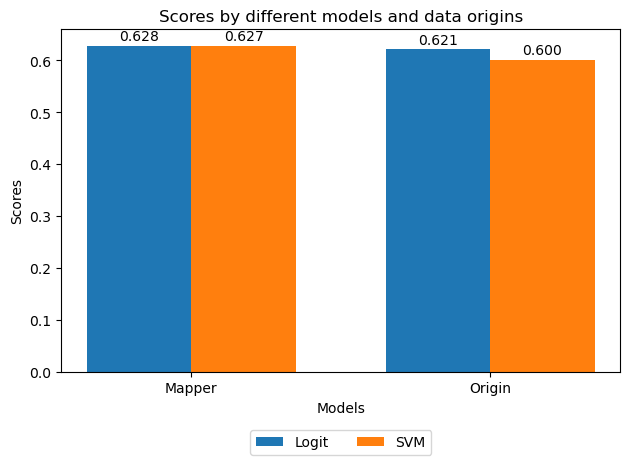

In [31]:
categories = ['Mapper', 'Origin']
logit_scores = [logit_avg_score, score_origin]
svm_scores = [svc_avg_score, svc_score_origin]

x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars, adjusted for better visualization

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, logit_scores, width, label='Logit')
rects3 = ax.bar(x + width/2, svm_scores, width, label='SVM')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by different models and data origins')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)  # adjusted legend positioning

# Attach a text label above each bar in *rects*, displaying its height.
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # slight vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects3)

fig.tight_layout()

plt.show()

fig.savefig('CalculatedData/所有分析.png')